In [1]:
# import the modules
import gymnasium as gym

# import the necessary packages for torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
env = gym.make("CarRacing-v3")


obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.render()
env.close()

/opt/homebrew/Caskroom/miniconda/base/envs/RepresentationLearning/lib/python3.12/site-packages/gymnasium/envs/box2d/car_racing.py:593: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CarRacing-v3", render_mode="rgb_array")
  gym.logger.warn(


In [2]:
AE_loss = []
VQ_VAE_loss = []

Training forward model...
Epoch 1/5, Loss: 0.0454
Epoch 2/5, Loss: 0.0132
Epoch 3/5, Loss: 0.0074
Epoch 4/5, Loss: 0.0069
Epoch 5/5, Loss: 0.0065


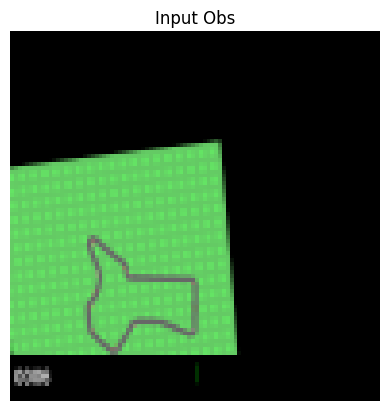

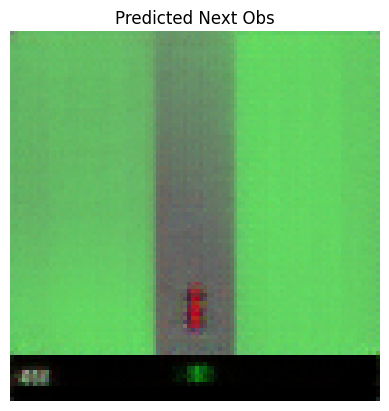

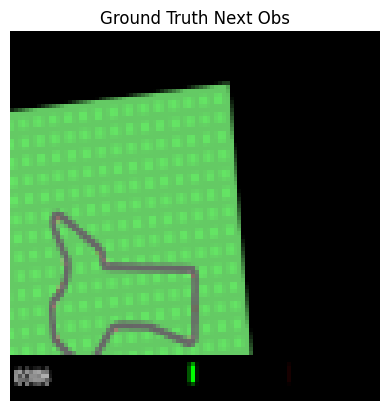

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")

# ---------- Encoder ----------
class Encoder(nn.Module):
    def __init__(self, image_height, image_width, channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        dummy = torch.zeros(1, channels, image_height, image_width)
        x = F.relu(self.conv1(dummy))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        self.shape_before_flattening = x.shape[1:]
        flattened_size = x.view(1, -1).shape[1]
        self.fc = nn.Linear(flattened_size, embedding_dim)

    def forward(self, x):
        x = x.float() / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---------- Decoder ----------
class Decoder(nn.Module):
    def __init__(self, shape_before_flattening, channels, embedding_dim, output_height=96, output_width=96):
        super(Decoder, self).__init__()
        self.shape = shape_before_flattening
        self.output_height = output_height
        self.output_width = output_width

        self.fc = nn.Linear(embedding_dim, np.prod(self.shape))
        self.deconv1 = nn.ConvTranspose2d(self.shape[0], 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), *self.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

# ---------- Forward Model (Encoder + Action + Decoder) ----------
class ForwardModel(nn.Module):
    def __init__(self, encoder, decoder, action_dim, embedding_dim):
        super(ForwardModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
        self.fc = nn.Linear(embedding_dim * 2, embedding_dim)

    def forward(self, obs, action):
        obs_emb = self.encoder(obs)
        action_emb = self.action_net(action)
        combined = torch.cat([obs_emb, action_emb], dim=1)
        fused = F.relu(self.fc(combined))
        next_obs_pred = self.decoder(fused)
        return next_obs_pred

# ---------- Utility ----------
def show_rgb_image(image_tensor, title=""):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ---------- Hyperparameters ----------
collect_step = 1000
train_epochs = 5
batch_size = 32
embedding_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Build model ----------
obs_sample = env.reset(seed=42)[0]
H, W, C = obs_sample.shape
action_dim = env.action_space.shape[0]

encoder = Encoder(H, W, C, embedding_dim).to(device)
decoder = Decoder(encoder.shape_before_flattening, C, embedding_dim, output_height=H, output_width=W).to(device)
model = ForwardModel(encoder, decoder, action_dim=action_dim, embedding_dim=embedding_dim).to(device)

# ---------- Collect data ----------
obs_arr, act_arr, next_arr = [], [], []
obs, _ = env.reset()
for _ in range(collect_step):
    action = env.action_space.sample()
    next_obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    obs_arr.append(torch.tensor(obs.transpose(2, 0, 1), dtype=torch.float))
    next_arr.append(torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float))
    act_arr.append(torch.tensor(action, dtype=torch.float))

    if done:
        obs, _ = env.reset()
    else:
        obs = next_obs

obs_tensor = torch.stack(obs_arr).to(device)
next_tensor = torch.stack(next_arr).to(device)
action_tensor = torch.stack(act_arr).to(device)

# ---------- Train ----------
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Training forward model...")
for epoch in range(train_epochs):
    perm = torch.randperm(obs_tensor.size(0))
    total_loss = 0
    for i in range(0, obs_tensor.size(0), batch_size):
        idx = perm[i:i+batch_size]
        obs_batch = obs_tensor[idx] / 255.0
        next_batch = next_tensor[idx] / 255.0
        action_batch = action_tensor[idx]

        optimizer.zero_grad()
        pred_next = model(obs_batch, action_batch)
        loss = loss_fn(pred_next, next_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (obs_tensor.size(0) / batch_size)
    AE_loss.append(avg_loss)
    print(f"Epoch {epoch+1}/{train_epochs}, Loss: {avg_loss:.4f}")

# ---------- Inference ----------
with torch.no_grad():
    sample_idx = 0
    obs_sample = obs_tensor[sample_idx].unsqueeze(0).to(device) / 255.0
    action_sample = action_tensor[sample_idx].unsqueeze(0).to(device)
    gt_next = next_tensor[sample_idx]

    pred_next = model(obs_sample, action_sample)[0]

    show_rgb_image(obs_tensor[sample_idx] / 255.0, title="Input Obs")
    show_rgb_image(pred_next, title="Predicted Next Obs")
    show_rgb_image(gt_next / 255.0, title="Ground Truth Next Obs")


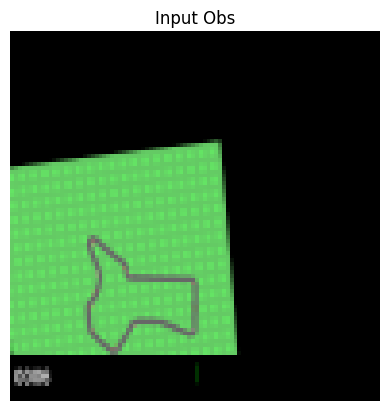

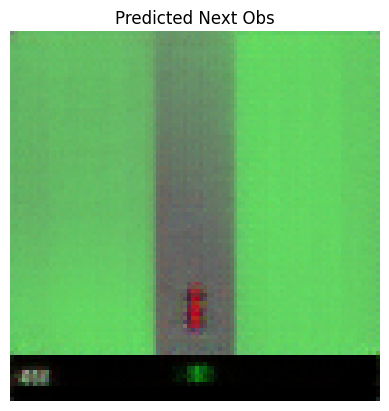

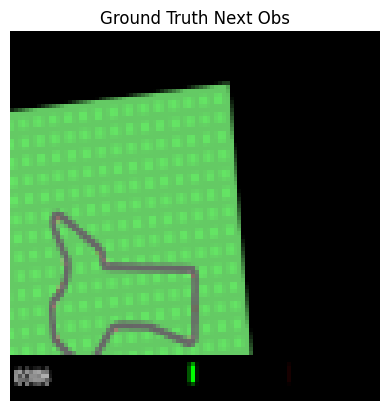

In [5]:
# ---------- Inference ----------
with torch.no_grad():
    sample_idx = 0
    obs_sample = obs_tensor[sample_idx].unsqueeze(0).to(device) / 255.0
    action_sample = action_tensor[sample_idx].unsqueeze(0).to(device)
    gt_next = next_tensor[sample_idx]

    pred_next = model(obs_sample, action_sample)[0]

    show_rgb_image(obs_tensor[sample_idx] / 255.0, title="Input Obs")
    show_rgb_image(pred_next, title="Predicted Next Obs")
    show_rgb_image(gt_next / 255.0, title="Ground Truth Next Obs")


# VQ VAE

In [ ]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from VQVAE import VQVAE
# ---- Utility to visualize RGB images ----
def show_rgb_image(image_tensor, title=""):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs_sample = env.reset()[0]
C, H, W = obs_sample.shape[2], obs_sample.shape[0], obs_sample.shape[1]

# ---- Use your VQVAE class here ----
# from your_module import VQVAE
vqvae = VQVAE(channel_in=C, ch=16, latent_channels=embedding_dim, code_book_size=32).to(device)
optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

# ---------- Hyperparameters ----------



# ---- Data Collection ----
obs_arr = []
obs = env.reset()[0]
for _ in range(collect_step):
    action = env.action_space.sample()
    next_obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    obs_arr.append(torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float))

    if done:
        obs = env.reset()[0]
    else:
        obs = next_obs

obs_tensor = torch.stack(obs_arr) / 255.0  # Normalize
dataset = DataLoader(TensorDataset(obs_tensor), batch_size=batch_size, shuffle=True)

# ---- Training ----
for epoch in range(train_epochs):
    total_loss = 0
    for (obs_batch,) in dataset:
        obs_batch = obs_batch.to(device)
        recon, vq_loss, _ = vqvae(obs_batch)
        recon_loss = mse_loss(recon, obs_batch)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    VQ_VAE_loss.append(total_loss / len(dataset))

    print(f"Epoch {epoch+1}/{train_epochs} - Loss: {total_loss / len(dataset):.4f}")

# ---- Inference ----
with torch.no_grad():
    idx = 0
    sample = obs_tensor[idx].unsqueeze(0).to(device)
    recon, _, _ = vqvae(sample)

    show_rgb_image(sample[0], title="Original Observation")
    show_rgb_image(recon[0], title="Reconstructed Observation")


In [ ]:
import matplotlib.pyplot as plt

# Example usage: Replace with your actual loss data if needed
# AE_loss = [...]
# VQ_VAE_loss = [...]

plt.figure(figsize=(10, 5))
plt.plot(AE_loss, label="AE Loss", color="blue")
plt.plot(VQ_VAE_loss, label="VQ-VAE Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder vs VQ-VAE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
